In [4]:
%matplotlib inline
import os
import sys
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle as pk
sys.path.append('../')
import matplotlib 

In [2]:
%load_ext autoreload
%autoreload 2
import libparam as method

usage: ipykernel_launcher.py [-h] [-ivt] [-ivp] [-dd] [-delens] [-cl] [-lh]
                             inifile
ipykernel_launcher.py: error: unrecognized arguments: -f


Simulation uses /project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD_old/LiteBird/RS/Maps
Delensing uses QE: p_eb
Workspace intializing from /project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD_old/LiteBird/RS/Pseudo_1024/workspace/coupling_matrix.fits


Bandpower calculated


Mean and STD of Bandpower: 100%|██████████| 100/100 [00:00<00:00, 2599.15simulation/s]


Fitting Delensed spectra between l=30 and l=150


Mean and STD of Bandpower: 100%|██████████| 100/100 [00:00<00:00, 5002.87simulation/s]

Likelihood:simple


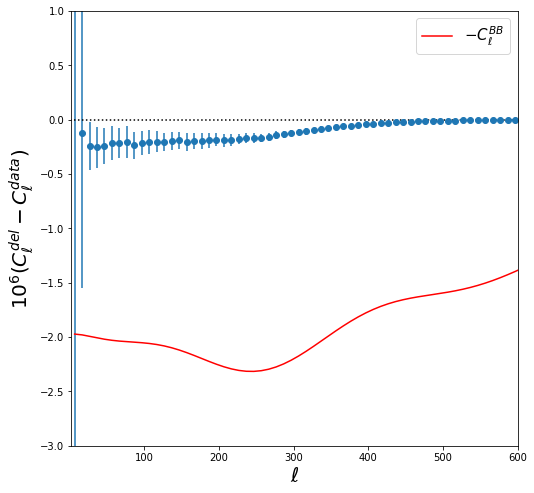

In [5]:
method.eff_lib.plot_spectrum_difference(600)


'5.77e-04'

<Figure size 576x576 with 0 Axes>

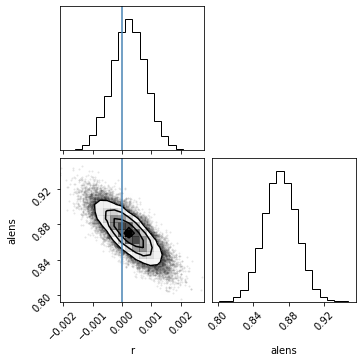

In [5]:
method.lh_lib.plot_posterior()
method.lh_lib.sigma_r()

'6.33e-04'

<Figure size 576x576 with 0 Axes>

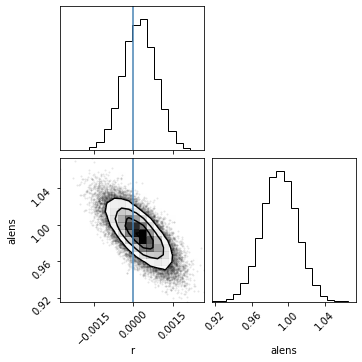

In [5]:
method.lh_lib.plot_posterior()
method.lh_lib.sigma_r()

'4.49e-04'

<Figure size 576x576 with 0 Axes>

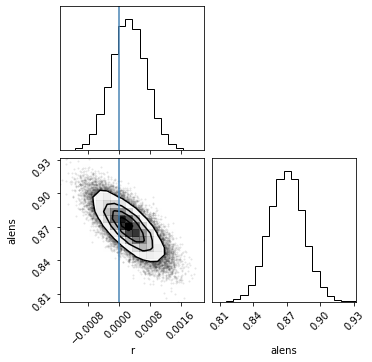

In [6]:
method.lh_lib.plot_posterior()
method.lh_lib.sigma_r()

In [7]:
1 - 4.49/6.33

0.2906793048973143

In [39]:
1-3/3.4

0.11764705882352944

'4.46e-04'

<Figure size 576x576 with 0 Axes>

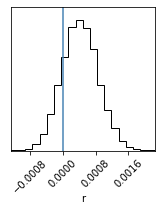

In [46]:
method.lh_lib.plot_posterior(0)
method.lh_lib.sigma_r(0)

'3.00e-04'

<Figure size 576x576 with 0 Axes>

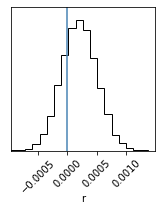

In [5]:
method.lh_lib.plot_posterior(0)
method.lh_lib.sigma_r(0)

In [4]:
1-3.6/4.4

0.18181818181818188

In [8]:
method.cov_lib.delensed_fid/method.cov_lib.lensed_fid

array([0.89303772, 0.89793437, 0.90822519, 0.90646917, 0.90766151,
       0.89520187, 0.90244601, 0.90400997, 0.90399775, 0.90025595,
       0.9027783 , 0.90265698])